In [1]:
import sys
from os import path
_up_one = path.abspath('../')
if _up_one not in sys.path:
    sys.path.insert(1, _up_one)

# Third-party
from astropy.io import ascii
import astropy.table as at
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.integrate import tplquad
from scipy.optimize import minimize

import gala.potential as gp
from gala.units import galactic
from lg_barycentric import LocalGroupBarycentric

In [2]:
mw_mvir = 1.1E12 * u.Msun # 1, 1.25, 1.5
mw_rs = 15.62 * u.kpc # 15, 20, 25
mw_rvir = 250. * u.kpc
c = mw_rvir / mw_rs
mw_mass = mw_mvir / (np.log(1 + c) - c / (1 + c))

m31_mvir = 1.5E12 * u.Msun
m31_rvir = 300 * u.kpc
m31_rs = m31_rvir / c
m31_mass = m31_mvir / (np.log(1 + c) - c / (1 + c))

c

<Quantity 16.00512164>

In [3]:
lg_bary = LocalGroupBarycentric(mw_mass=mw_mass, m31_mass=m31_mass)

m31_cen = coord.SkyCoord(ra='00 42 44.330', dec='+41 16 07.50', distance=779*u.kpc,
                         unit=(u.hourangle, u.degree))
m31_cen = m31_cen.transform_to(lg_bary)

mw_cen = coord.Galactocentric(x=0*u.pc, y=0*u.pc, z=0*u.pc)
mw_cen = mw_cen.transform_to(lg_bary)

In [4]:
m31_xyz = m31_cen.cartesian.xyz.to(u.kpc)
mw_cen.cartesian.xyz.to(u.kpc), m31_xyz

(<Quantity [-451.74764654,    0.        ,    0.        ] kpc>,
 <Quantity [ 3.31281607e+02,  3.40473946e-07, -1.01468913e-08] kpc>)

From Mathematica: Intertia tensor notebook

In [5]:
# qs = dict()

# qs[(1e12*u.Msun, 15*u.kpc)] = 0.386967
# qs[(1e12*u.Msun, 20*u.kpc)] = 0.408714
# qs[(1e12*u.Msun, 25*u.kpc)] = 0.426762

# qs[(1.25e12*u.Msun, 15*u.kpc)] = 0.37111
# qs[(1.25e12*u.Msun, 20*u.kpc)] = 0.39251
# qs[(1.25e12*u.Msun, 25*u.kpc)] = 0.41032

# qs[(1.5e12*u.Msun, 15*u.kpc)] = 0.36273
# qs[(1.5e12*u.Msun, 20*u.kpc)] = 0.38396
# qs[(1.5e12*u.Msun, 25*u.kpc)] = 0.40166

# q = qs[(mw_mvir, mw_rs)]

q = 0.366411
print(q)

0.366411


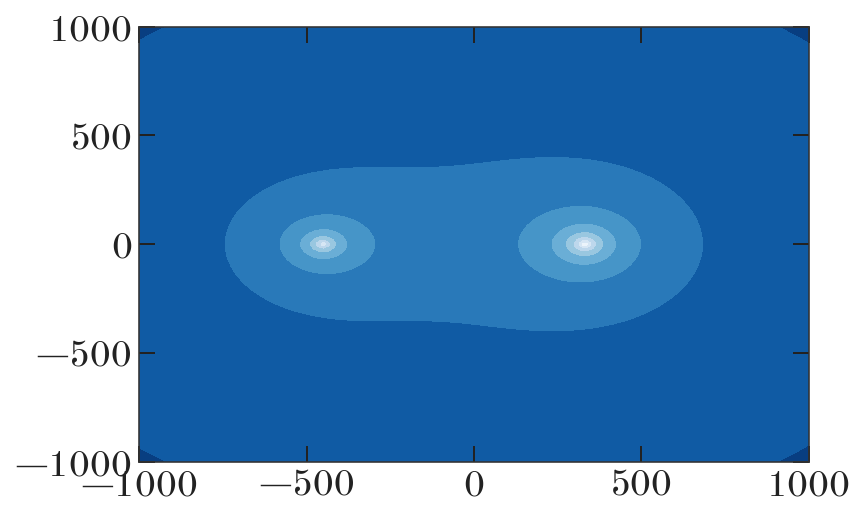

In [6]:
pot = gp.CCompositePotential()

pot['mw'] = gp.NFWPotential(m=mw_mass, r_s=mw_rs, 
                            units=galactic,
                            origin=mw_cen.cartesian.xyz.to(u.kpc))

pot['m31'] = gp.NFWPotential(m=m31_mass, r_s=m31_rs, 
                             units=galactic,
                             origin=m31_cen.cartesian.xyz)

grid = np.linspace(-1000, 1000, 128)*u.kpc
_ = pot.plot_contours(grid=(grid, 0, grid), )

---

In [25]:
# nearby = ascii.read('../data/NearbyGalaxiese_formatted.txt')
# ra = (nearby['RA_h']+nearby['RA_m']/60.+nearby['RA_s']/3600) * u.hourangle
# dec = (nearby['Dec_d']+nearby['Dec_m']/60+nearby['Dec_s']/3600) * u.degree
# dist = coord.Distance(distmod=nearby['Dist'])

nearby = ascii.read('../data/dwarfs.csv')[2:] # skip MW and Canis Major
ra = (nearby['RA_hr']+nearby['RA_min']/60.+nearby['RA_sec']/3600) * u.hourangle
dec = (nearby['Dec_deg']+nearby['Dec_arcmin']/60+nearby['Dec_arcsec']/3600) * u.degree
dist = coord.Distance(distmod=nearby['m-M'])

In [26]:
# def func(z, y, x, i1, i2):
#     arr = [x, y, z]
#     return pot._density(np.array([[x, y, z]]), t=np.array([0.])) * arr[i1] * arr[i2]

In [27]:
# lim = 1000
# res = tplquad(func,
#               a=-lim, b=lim, 
#               gfun=lambda *args: -lim, hfun=lambda *args: lim, 
#               qfun=lambda *args: -lim, rfun=lambda *args: lim,
#               args=(0, 0), epsabs=1E-1, epsrel=1E-4)

In [28]:
c = coord.SkyCoord(ra=ra, dec=dec, distance=dist,
                   unit=(u.hourangle, u.deg))

In [29]:
c_barycen = c.transform_to(lg_bary)

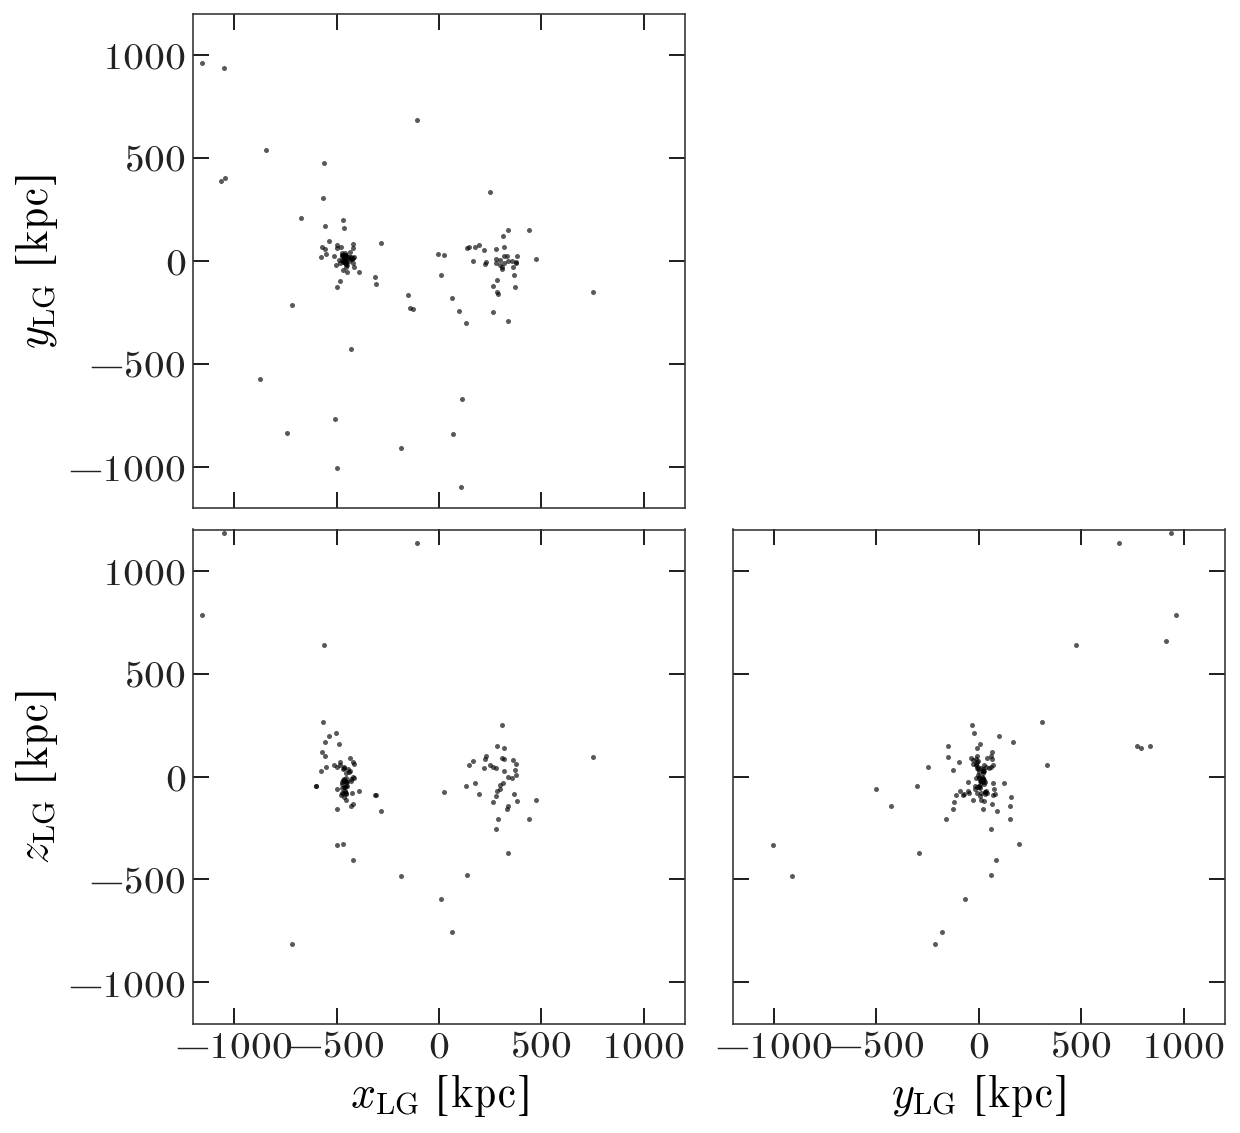

In [30]:
style = dict(marker='.', linestyle='none', alpha=0.65)

fig, axes = plt.subplots(2, 2, figsize=(8.75,8), sharex=True, sharey=True)

axes[0,0].plot(c_barycen.cartesian.xyz[0],
               c_barycen.cartesian.xyz[1],
               **style)
axes[1,0].plot(c_barycen.cartesian.xyz[0],
               c_barycen.cartesian.xyz[2],
               **style)
axes[1,1].plot(c_barycen.cartesian.xyz[1],
               c_barycen.cartesian.xyz[2],
               **style)

axes[0,0].set_xlim(-1200, 1200)
axes[0,0].set_ylim(-1200, 1200)

axes[0,0].set_ylabel(r'$y_{\rm LG}$ [kpc]')
axes[1,0].set_ylabel(r'$z_{\rm LG}$ [kpc]')
axes[1,0].set_xlabel(r'$x_{\rm LG}$ [kpc]')
axes[1,1].set_xlabel(r'$y_{\rm LG}$ [kpc]')

axes[0,0].xaxis.set_ticks(np.arange(-1000, 1000+1, 500))
axes[0,0].yaxis.set_ticks(axes[0,0].get_xticks())

axes[0,1].set_visible(False)

fig.tight_layout()

In [31]:
rstar = np.sqrt(m31_xyz[0]**2 + m31_rvir**2 / q**2).to_value(u.kpc)
rstar

883.2346840142924

In [32]:
def get_r(cosphi, sinphi, costhe, sinthe, re, q):
    t1 = cosphi**2 * sinthe**2
    t2 = (sinphi**2 * sinthe**2 + costhe**2) / q**2
    return re / np.sqrt(t1 + t2)

def get_xyz_ellipse(phi, the, re, q):
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)
    costhe = np.cos(the)
    sinthe = np.sin(the)
    
    r = get_r(cosphi, sinphi, costhe, sinthe, re, q)
    x = r * cosphi * sinthe
    y = r * sinphi * sinthe
    z = r * costhe
    
    return np.array([x, y, z])

def is_inside(pt, re, q):
    return (pt[0]**2 / re**2 + (pt[1]**2 + pt[2]**2) / (re**2 * q**2)) <= 1

In [33]:
phi_grid = np.linspace(0, 2*np.pi, 512)
the_grid = np.linspace(-np.pi/2, np.pi/2, 512)
ang_grid = np.vstack(map(np.ravel, np.meshgrid(phi_grid, the_grid)))

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
bary_xyz = c_barycen.cartesian.xyz.value

In [35]:
def func(p, xyz):
    phi, the = p
    xyz_el = get_xyz_ellipse(phi, the, rstar, q).T
    return np.sqrt(np.sum((xyz - xyz_el)**2, axis=-1))

In [36]:
closest_ell_xyz = np.zeros((3, bary_xyz.shape[1]))
for i in range(bary_xyz.shape[1]):
    res = minimize(func, ang_grid[:, func(ang_grid, bary_xyz[:, i]).argmin()], 
                   args=(bary_xyz[:, i],))
    
    if not res.success:
        print(i)
        
    closest_ell_xyz[:, i] = get_xyz_ellipse(res.x[0], res.x[1], rstar, q)

6
13
28
35
38
70
78
79
84
105
106
110
114
115
117
118
120
125
126
128
138


/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


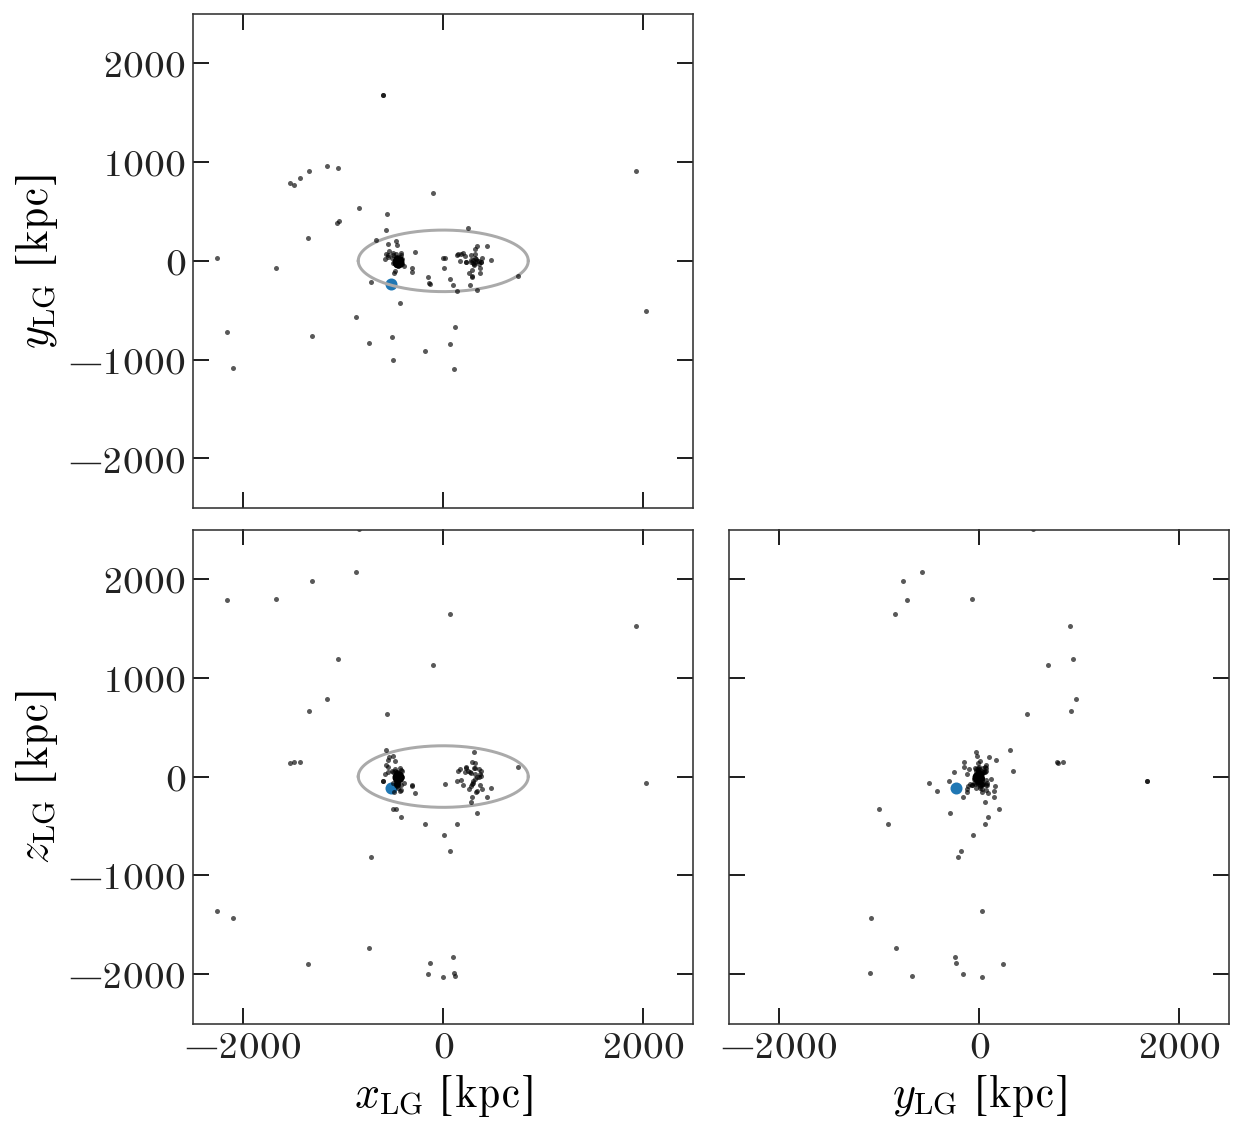

In [37]:
i = 0

fig, axes = plt.subplots(2, 2, figsize=(8.75,8), sharex=True, sharey=True)

rstar = 850.
y1 = q * np.sqrt(rstar**2 - xgrid**2)
y2 = -q * np.sqrt(rstar**2 - xgrid**2)
axes[0, 0].plot(xgrid, y1, marker='', color='#aaaaaa')
axes[0, 0].plot(xgrid, y2, marker='', color='#aaaaaa')
axes[1, 0].plot(xgrid, y1, marker='', color='#aaaaaa')
axes[1, 0].plot(xgrid, y2, marker='', color='#aaaaaa')

style = dict(marker='.', linestyle='none', alpha=0.65)

axes[0,0].plot(c_barycen.cartesian.xyz[0],
               c_barycen.cartesian.xyz[1],
               **style)
axes[1,0].plot(c_barycen.cartesian.xyz[0],
               c_barycen.cartesian.xyz[2],
               **style)
axes[1,1].plot(c_barycen.cartesian.xyz[1],
               c_barycen.cartesian.xyz[2],
               **style)

axes[0,0].scatter(c_barycen.cartesian.xyz[0, i],
                  c_barycen.cartesian.xyz[1, i])
axes[1,0].scatter(c_barycen.cartesian.xyz[0, i],
                  c_barycen.cartesian.xyz[2, i])
axes[1,1].scatter(c_barycen.cartesian.xyz[1, i],
                  c_barycen.cartesian.xyz[2, i])

axes[0,0].scatter(closest_ell_xyz[0, i],
                  closest_ell_xyz[1, i])
axes[1,0].scatter(closest_ell_xyz[0, i],
                  closest_ell_xyz[2, i])
axes[1,1].scatter(closest_ell_xyz[1, i],
                  closest_ell_xyz[2, i])

axes[0,0].set_xlim(-2500, 2500)
axes[0,0].set_ylim(-2500, 2500)

axes[0,0].set_ylabel(r'$y_{\rm LG}$ [kpc]')
axes[1,0].set_ylabel(r'$z_{\rm LG}$ [kpc]')
axes[1,0].set_xlabel(r'$x_{\rm LG}$ [kpc]')
axes[1,1].set_xlabel(r'$y_{\rm LG}$ [kpc]')

axes[0,1].set_visible(False)

fig.tight_layout()

In [38]:
r_ell = np.sqrt(c_barycen.x**2 + (c_barycen.y**2 + c_barycen.z**2) / q**2)
surf_dist = np.sqrt(np.sum((bary_xyz - closest_ell_xyz)**2, axis=0))
surf_dist[is_inside(bary_xyz, rstar, q)] *= -1

In [47]:
has = ['left', 'right']
vas = ['top', 'bottom']

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in sqrt


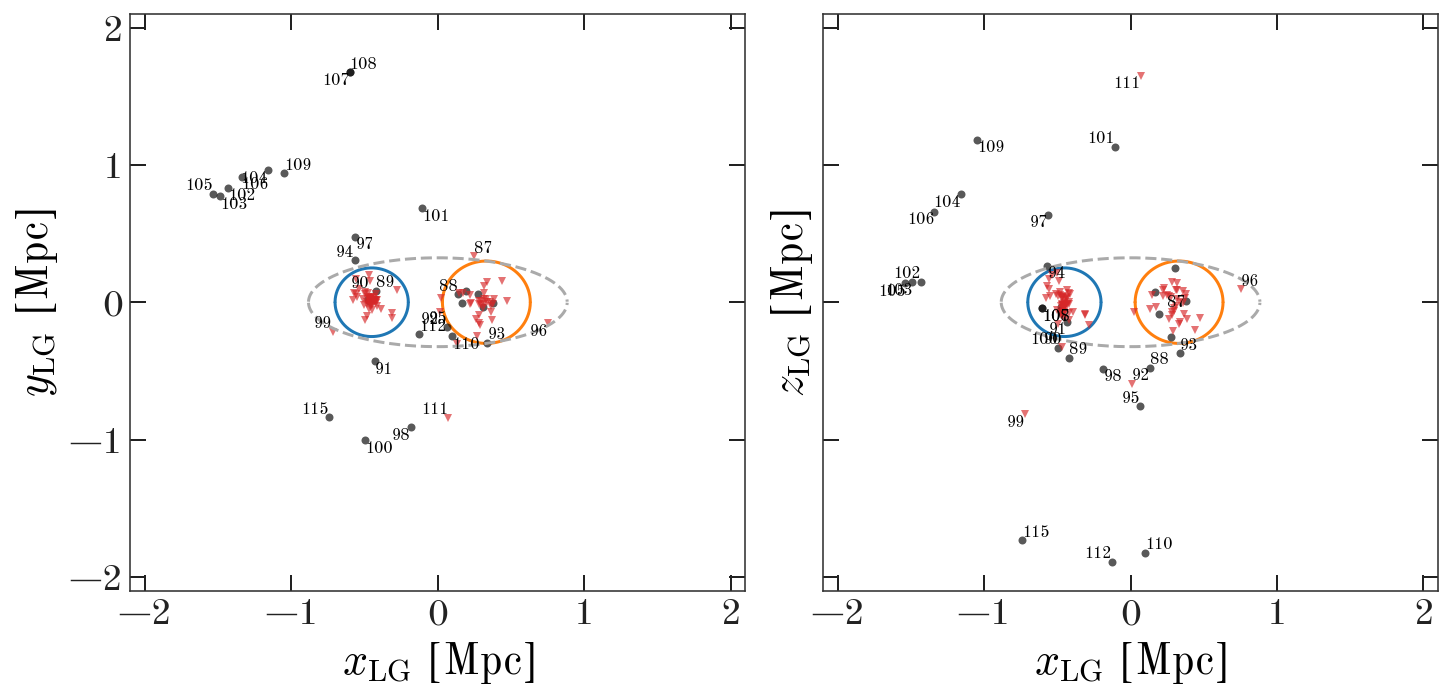

In [53]:
xgrid = np.linspace(-1000, 1000, 16384)
mask = c.distance < 2*u.Mpc
np.random.seed(1234)

fig, axes = plt.subplots(1, 2, figsize=(10.2, 5), 
                         sharex=True, sharey=True)

has_HI = nearby['MHI_type'] == 'detected_mass'

for i, ax in zip([1, 2], axes):
    ax.plot(c_barycen.cartesian.xyz[0][mask & has_HI].to(u.Mpc),
            c_barycen.cartesian.xyz[i][mask & has_HI].to(u.Mpc),
            marker='o', ms=4, mew=0, linestyle='none', alpha=0.65)
    ax.plot(c_barycen.cartesian.xyz[0][mask & ~has_HI].to(u.Mpc),
            c_barycen.cartesian.xyz[i][mask & ~has_HI].to(u.Mpc),
            marker='v', ms=4, mew=0, linestyle='none', alpha=0.65, color='tab:red')
    
    for idx in np.where(mask & has_HI & (surf_dist > 0))[0]:
        t = ax.text(c_barycen.cartesian.xyz[0][idx].to_value(u.Mpc),
                    c_barycen.cartesian.xyz[i][idx].to_value(u.Mpc),
                    s=str(nearby[idx]['id']), fontsize=8, 
                    ha=np.random.choice(has), va=np.random.choice(vas))
        
    for idx in np.where(mask & ~has_HI & (surf_dist > 0))[0]:
        t = ax.text(c_barycen.cartesian.xyz[0][idx].to_value(u.Mpc),
                    c_barycen.cartesian.xyz[i][idx].to_value(u.Mpc),
                    s=str(nearby[idx]['id']), fontsize=8, 
                    ha=np.random.choice(has), va=np.random.choice(vas))
    
_mw_xyz = mw_cen.cartesian.xyz.to(u.kpc).value
rvir = 250.
y1 = np.sqrt(rvir**2 - (xgrid - _mw_xyz[0])**2)
y2 = -np.sqrt(rvir**2 - (xgrid - _mw_xyz[0])**2)
for ax in axes:
    ax.plot(xgrid / 1e3, y1 / 1e3, 
            marker='', color='tab:blue', zorder=-10)
    ax.plot(xgrid / 1e3, y2 / 1e3, 
            marker='', color='tab:blue', zorder=-10)

_m31_xyz = m31_cen.cartesian.xyz.to(u.kpc).value
rvir = 300.
y1 = np.sqrt(rvir**2 - (xgrid - _m31_xyz[0])**2)
y2 = -np.sqrt(rvir**2 - (xgrid - _m31_xyz[0])**2)
for ax in axes:
    ax.plot(xgrid / 1e3, y1 / 1e3, 
            marker='', color='tab:orange', zorder=-10)
    ax.plot(xgrid / 1e3, y2 / 1e3, 
            marker='', color='tab:orange', zorder=-10)

rstar = np.sqrt(m31_xyz[0]**2 + m31_rvir**2 / q**2).to_value(u.kpc)
y1 = q * np.sqrt(rstar**2 - xgrid**2)
y2 = -q * np.sqrt(rstar**2 - xgrid**2)
for ax in axes:
    ax.plot(xgrid / 1e3, y1 / 1e3, marker='', ls='--', color='#aaaaaa')
    ax.plot(xgrid / 1e3, y2 / 1e3, marker='', ls='--', color='#aaaaaa')
    
    _lim = 2.1
    ax.set_xlim(-_lim, _lim)
    ax.set_ylim(-_lim, _lim)

    ax.set_xlabel(r'$x_{\rm LG}$ [Mpc]')
axes[0].set_ylabel(r'$y_{\rm LG}$ [Mpc]')
axes[1].set_ylabel(r'$z_{\rm LG}$ [Mpc]')

fig.tight_layout()
fig.set_facecolor('w')
fig.savefig('../plots/rvir_ell_labeled.pdf')

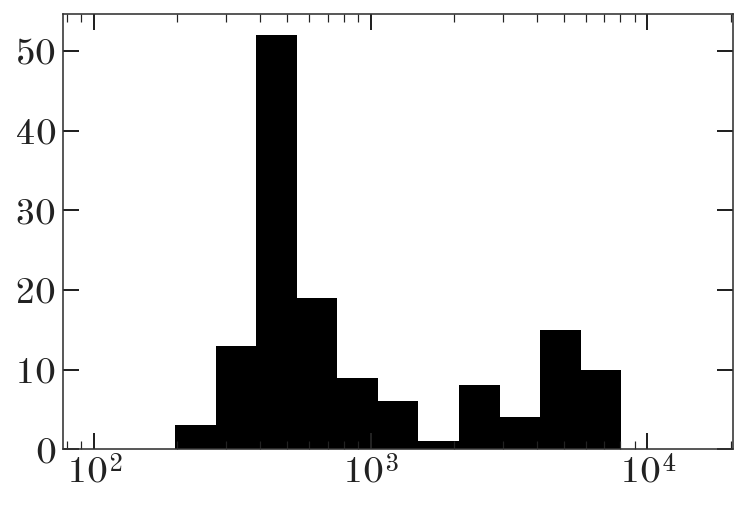

In [43]:
plt.hist(r_ell.value, bins=np.logspace(2, 4.2, 16));
plt.xscale('log')

(array([94.,  9.,  2.,  3.,  6.,  4.,  6.,  8.,  5.,  3.]),
 array([-2.95352016e+02,  2.31332027e+00,  2.99978657e+02,  5.97643993e+02,
         8.95309330e+02,  1.19297467e+03,  1.49064000e+03,  1.78830534e+03,
         2.08597068e+03,  2.38363601e+03,  2.68130135e+03]),
 <a list of 10 Patch objects>)

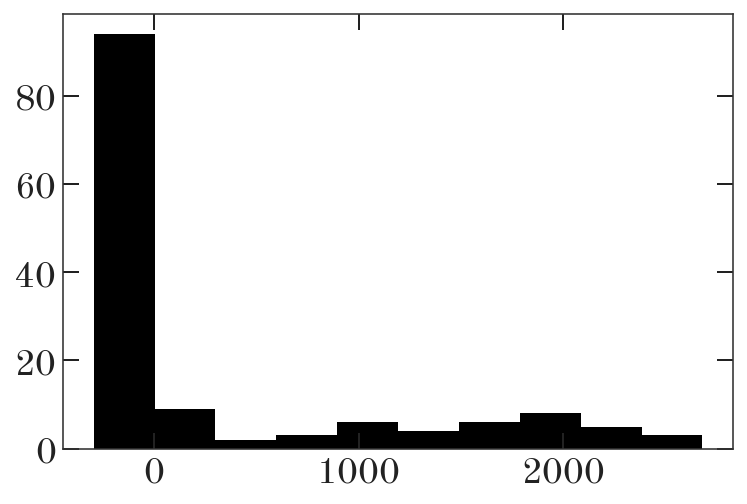

In [44]:
plt.hist(surf_dist) #, bins=np.logspace(2, 4.2, 16));
# plt.xscale('log')

In [47]:
nearby['r_ell'] = r_ell
nearby['ell_surf_dist'] = surf_dist

In [46]:
dM31 = (c_barycen.cartesian - m31_cen.cartesian).norm()
dMW = (c_barycen.cartesian - mw_cen.cartesian).norm()
nearby['mw_dist'] = dMW
nearby['m31_dist'] = dM31

In [49]:
nearby.write('../data/dwarfs_ell.csv', overwrite=True)

---

OLD: Back when we were computing many M models

In [45]:
# nearby.write('../data/tmp_dwarfs_m{0:.1f}_rs{1:.0f}.csv'.format((mw_mvir.value/1e12), mw_rs.value), 
#              format='ascii.csv', overwrite=True)

# Combine the files:

In [311]:
import glob
import re

In [312]:
dM31 = (c_barycen.cartesian - m31_cen.cartesian).norm()
dMW = (c_barycen.cartesian - mw_cen.cartesian).norm()

In [313]:
pattr = re.compile('(m[0-9\.]+_rs[0-9]+)')

nearby_joint = ascii.read('../data/dwarfs.csv')[2:]

for f in glob.glob('../data/tmp_dwarfs_*.csv'):
    name = pattr.search(f).groups()[0]
    tbl = ascii.read(f)
    nearby_joint['r_ell_' + name] = tbl['r_ell']
    nearby_joint['ell_surf_dist_' + name] = tbl['ell_surf_dist']
    
nearby_joint['mw_dist'] = dMW
nearby_joint['m31_dist'] = dM31

In [315]:
nearby_joint.write('../data/dwarfs_ell.csv')

In [316]:
# nearby_joint.write('../data/NearbyGalaxies_joint.dat', 
#              format='ascii', delimiter=' ', overwrite=True)